In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from sklearn.model_selection import train_test_split


from tf_logging import TF_LOGGING
from cnn_lstm import CNN_LSTM


tf_logging = TF_LOGGING()
cnn_lstm = CNN_LSTM().create_model()
cnn_lstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 12, 1)]           0         
                                                                 
 Conv2 (Conv1D)              (None, 12, 128)           256       
                                                                 
 LSTM1 (LSTM)                (None, 12, 128)           131584    
                                                                 
 LSTM2 (LSTM)                (None, 12, 128)           131584    
                                                                 
 LSTM3 (LSTM)                (None, 12, 128)           131584    
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 FC (Dense)                  (None, 1)                 1537  

## Loading Data

In [2]:
#Load the data
with open('X.pkl', 'rb') as f:
    X = pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y = pkl.load(f)

#Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

#Split into training, testing, and validation sets using scikit-learn
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

#Print the shapes and types of the data
print('X_train shape:', X_train.shape, 'type:', type(X_train))
print('Y_train shape:', Y_train.shape, 'type:', type(Y_train))
print('X_test shape:', X_test.shape, 'type:', type(X_test))
print('Y_test shape:', Y_test.shape, 'type:', type(Y_test))
print('X_val shape:', X_val.shape, 'type:', type(X_val))
print('Y_val shape:', Y_val.shape, 'type:', type(Y_val))

val_performance = {}
performance = {}

X_train shape: (310194, 12) type: <class 'numpy.ndarray'>
Y_train shape: (310194,) type: <class 'numpy.ndarray'>
X_test shape: (96936, 12) type: <class 'numpy.ndarray'>
Y_test shape: (96936,) type: <class 'numpy.ndarray'>
X_val shape: (77549, 12) type: <class 'numpy.ndarray'>
Y_val shape: (77549,) type: <class 'numpy.ndarray'>


In [3]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
cnn_lstm.compile(loss='mse', optimizer=Adam, metrics=[tf.keras.metrics.RootMeanSquaredError()])
cnn_lstm.fit(X_train,Y_train,epochs=10, validation_data=(X_val,Y_val))

# loss, accuracy = cnn_lstm.evaluate(X_test,Y_test)


# print(loss, accuracy)

Epoch 1/10
9694/9694 [==============================] - 169s 17ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 2/10
9694/9694 [==============================] - 166s 17ms/step - loss: 0.0351 - root_mean_squared_error: 0.1874 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 3/10
9694/9694 [==============================] - 168s 17ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 4/10
9694/9694 [==============================] - 167s 17ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 5/10
9694/9694 [==============================] - 167s 17ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1846
Epoch 6/10
9694/9694 [==============================] - 168s 17ms/step - loss: 0.0344 - root_mean_squared_error: 0.

## Plotting Function

In [3]:
def plot(inputs, labels, model=None, max_subplots=3):
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'Energy Generation [normed]')
    plt.plot(inputs[n],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(x=len(inputs[n]), y=labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      prediction = model(inputs[n])
      print(inputs[n])
      print(prediction)
      plt.scatter(x=len(inputs[n]), y=prediction,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Months]')

## Baseline Model

Just guess that the next data point is the same as the last data point.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    return inputs[-1]

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=["accuracy"])

val_performance = {}
performance = {}


performance['Baseline'] = baseline.evaluate(X_test, Y_test, verbose=2,batch_size=1)
val_performance['Baseline'] = baseline.evaluate(X_val, Y_val,verbose=2, batch_size=1)


performance

96936/96936 - 44s - loss: 0.0843 - accuracy: 0.0018 - 44s/epoch - 457us/step
77549/77549 - 35s - loss: 0.0851 - accuracy: 0.0019 - 35s/epoch - 457us/step


{'Baseline': [0.08425251394510269, 0.0018053147941827774]}

[0.84610814 0.86928105 0.44444444 0.31253714 0.85620915 0.71063577
 0.89156269 0.79916815 0.79144385 0.73262032 0.96286393 0.13161022]
tf.Tensor(0.13161021, shape=(), dtype=float32)
[0.80532464 0.79141349 0.76686926 0.77742252 0.76630957 0.81204032
 0.78134001 1.         0.83906303 0.93228341 0.68548133 0.58794375]
tf.Tensor(0.58794373, shape=(), dtype=float32)
[0.63804761 0.4929147  0.12290451 0.88941373 0.94359544 0.96063721
 0.97045476 0.83004538 0.87487265 0.86060943 0.68565342 0.1688432 ]
tf.Tensor(0.1688432, shape=(), dtype=float32)


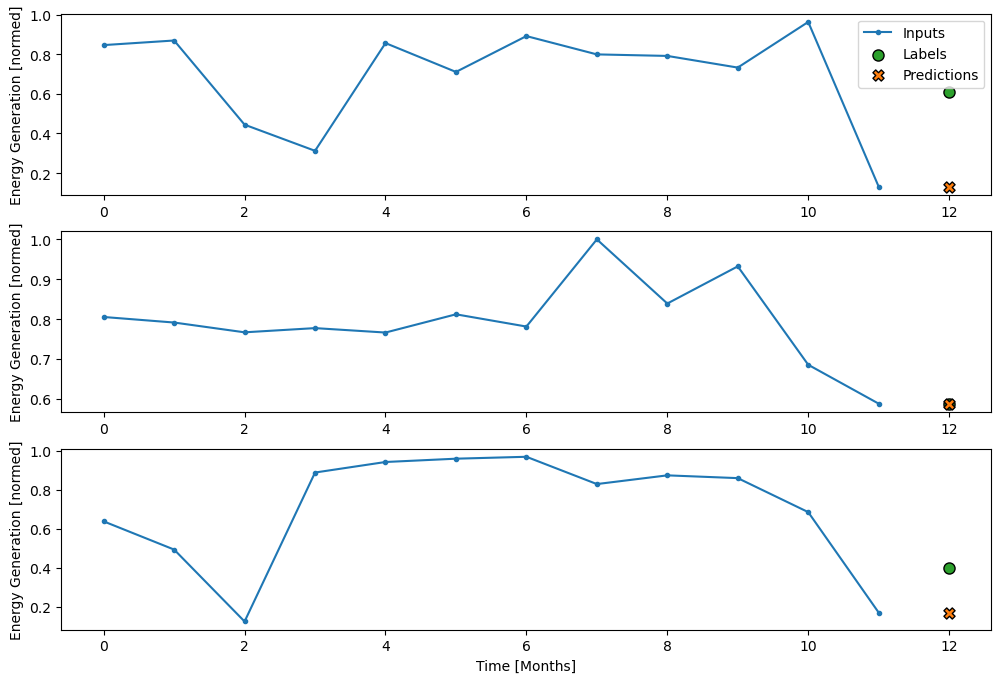

In [ ]:
plot(inputs=X_val, labels=Y_val, model=baseline)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 12, 1)]           0         
                                                                 
 Conv1 (Conv1D)              (None, 12, 1)             2         
                                                                 
 Conv2 (Conv1D)              (None, 12, 1)             2         
                                                                 
 MaxPool (MaxPooling1D)      (None, 6, 1)              0         
                                                                 
 LSTM1 (LSTM)                (None, 6, 1)              12        
                                                                 
 LSTM2 (LSTM)                (None, 6, 1)              12        
                                                                 
 LSTM3 (LSTM)                (None, 6, 1)              12    

KeyboardInterrupt: 